In [468]:
import numpy as np 
import pandas as pd 
import os
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from sklearn import preprocessing

from pytrends.request import TrendReq
pytrends = TrendReq()#hl='en-US', tz=360)
import time
from scipy.signal import savgol_filter

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=3.5, style="whitegrid")
plt.rcParams["figure.figsize"] = (80,30)

from itertools import islice

def sliding_window(seq, n=3):
    windows = []
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        #yield result
        windows.append(result)
    for elem in it:
        result = result[1:] + (elem,)
        #yield result
        windows.append(result)
    return windows

In [36]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


In [37]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


In [38]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results#sort the tf-idf vectors by descending order of scores


In [39]:
#!python -m spacy download en_core_web_md

In [40]:
import spacy
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from string import punctuation

print(list(punctuation))
nlp = spacy.load("en_core_web_md") #uncomment the code in the previous cell to download the model


['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [41]:
stop_words = set(stopwords.words('english'))

new_words = ["said", "inc", "year", "corp", "also", "net", "may", "com", "percent", "time", "new",
            'link', 'see']
stop_words = list(stop_words.union(new_words)) + list(punctuation)

new_stop_words = []
for stop_word in stop_words:
    new_stop_words.append(stop_word[0].upper() + stop_word[1:])

stop_words += new_stop_words

ps = PorterStemmer()
lem = WordNetLemmatizer()


def pre_process(text, return_tokens=True):
    clean = []
    for sent in sent_tokenize(text, language="french"):

        sent = sent.replace('¬\n', '')
        sent = sent.replace('\n', ' ')
        sent = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",sent)
        sent = re.sub('(\\d|\\W)',' ',sent)
        sent = re.sub(' +', ' ', sent)
        
        #doc = nlp(text)
        #for ent in doc.ents:
        #   # print(ent.text, ent.start_char, ent.end_char, ent.label_)
        #    if ent.label_ in ['DATE', 'MONEY', 'WORK_OF_ART', 'CARDINAL', 'PERCENT']:
        #        text = text.replace(ent.text, ' ')
        sent = re.sub(r'http\S+', '', sent)

        sent = sent.lower()
        words = word_tokenize(sent, language="french")
        temp_words = [word for word in words if word not in stop_words]
        temp_words = [word for word in temp_words if len(word) > 2]
        temp_words = [word for word in temp_words if not word.isupper()]
        temp_words = [word for word in temp_words if '$' not in word]
        temp_words = [word for word in temp_words if '@' not in word]
        temp_words = [word for word in temp_words if 'http' not in word]
        temp_words = [word for word in temp_words if 'www' not in word]
        temp_words = [word for word in temp_words if 'link' not in word]
        temp_words = [lem.lemmatize(word) for word in temp_words if lem.lemmatize(word) not in stop_words]
        
        clean += temp_words
    
    if return_tokens: 
        return clean
    else:
        return ' '.join(clean)


In [42]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words,ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]#Convert most freq words to dataframe for plotting bar plot


In [43]:
#from pytrends.request import TrendReq
#pytrends = TrendReq(hl='en-US', tz=360)

In [66]:
import pickle as pkl

#with open('data/MSFT_1907_noPreprocessing', 'rb') as f:
with open('data/MSFT_Jul2019_2020_linebreak', 'rb') as f:
    data = pkl.load(f)

In [67]:
data.head()

time                                           headline  \
119  07:30:05.959000  Avaya Expands Platform Choice for Its Market-l...   
394  11:50:00.412000  Compare the Best Xbox One & Live Black Friday ...   
567  09:36:00.297000  Nintendo Switch, Xbox One & PS4 Prime Day Deal...   
575  12:33:00.343000  PC, Laptop, Printer, WiFi Router, SSD & Monito...   
610  14:30:05.599000  Surface Pro Cyber Monday Deals 2019: Surface P...   

                                                  text  \
119  Avaya Expands Platform Choice for Its Market-l...   
394  Compare the Best Xbox One & Live Black Friday ...   
567  Nintendo Switch, Xbox One & PS4 Prime Day Deal...   
575  PC, Laptop, Printer, WiFi Router, SSD & Monito...   
610  Surface Pro Cyber Monday Deals 2019: Surface P...   

                                               dtopics  \
119  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...   
394  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CO...   
567  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...   
575  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'ER...   
610  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CO...   

                                              dtickers        date  
119  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'AVYA'...  2019-10-06  
394                   [{'Id': 'MSFT', 'score': '100'}]  2019-11-17  
567  [{'Id': 'MSFT', 'score': '100'}, {'Id': '7974@...  2019-07-14  
575  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'DELL'...  2019-07-14  
610                   [{'Id': 'MSFT', 'score': '100'}]  2019-11-30

In [90]:
data['year'] = data['date'].apply(lambda date: int(str(date)[:4]))
data['month'] = data['date'].apply(lambda date: str(date)[:7])
data['day'] = data['date'].apply(lambda date: str(date)[:10])

data.head()

time                                           headline  \
119  07:30:05.959000  Avaya Expands Platform Choice for Its Market-l...   
394  11:50:00.412000  Compare the Best Xbox One & Live Black Friday ...   
567  09:36:00.297000  Nintendo Switch, Xbox One & PS4 Prime Day Deal...   
575  12:33:00.343000  PC, Laptop, Printer, WiFi Router, SSD & Monito...   
610  14:30:05.599000  Surface Pro Cyber Monday Deals 2019: Surface P...   

                                                  text  \
119  Avaya Expands Platform Choice for Its Market-l...   
394  Compare the Best Xbox One & Live Black Friday ...   
567  Nintendo Switch, Xbox One & PS4 Prime Day Deal...   
575  PC, Laptop, Printer, WiFi Router, SSD & Monito...   
610  Surface Pro Cyber Monday Deals 2019: Surface P...   

                                               dtopics  \
119  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...   
394  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CO...   
567  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...   
575  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'ER...   
610  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CO...   

                                              dtickers        date  year  \
119  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'AVYA'...  2019-10-06  2019   
394                   [{'Id': 'MSFT', 'score': '100'}]  2019-11-17  2019   
567  [{'Id': 'MSFT', 'score': '100'}, {'Id': '7974@...  2019-07-14  2019   
575  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'DELL'...  2019-07-14  2019   
610                   [{'Id': 'MSFT', 'score': '100'}]  2019-11-30  2019   

       month         day                                             tokens  \
119  2019-10  2019-10-06  [october, gitex, technology, week, avaya, glob...   
394  2019-11  2019-11-17  [november, find, early, xbox, one, xbox, live,...   
567  2019-07  2019-07-14  [july, xbox, playstation, nintendo, prime, day...   
575  2019-07  2019-07-14  [july, team, prime, day, sale, expert, deal, t...   
610  2019-11  2019-11-30  [november, surface, cyber, monday, deal, shown...   

     freq  
119   0.0  
394   0.0  
567   0.0  
575   0.0  
610   0.0

In [47]:
len(data)

11923

(array([18078., 18140., 18201., 18262., 18322., 18383., 18444.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

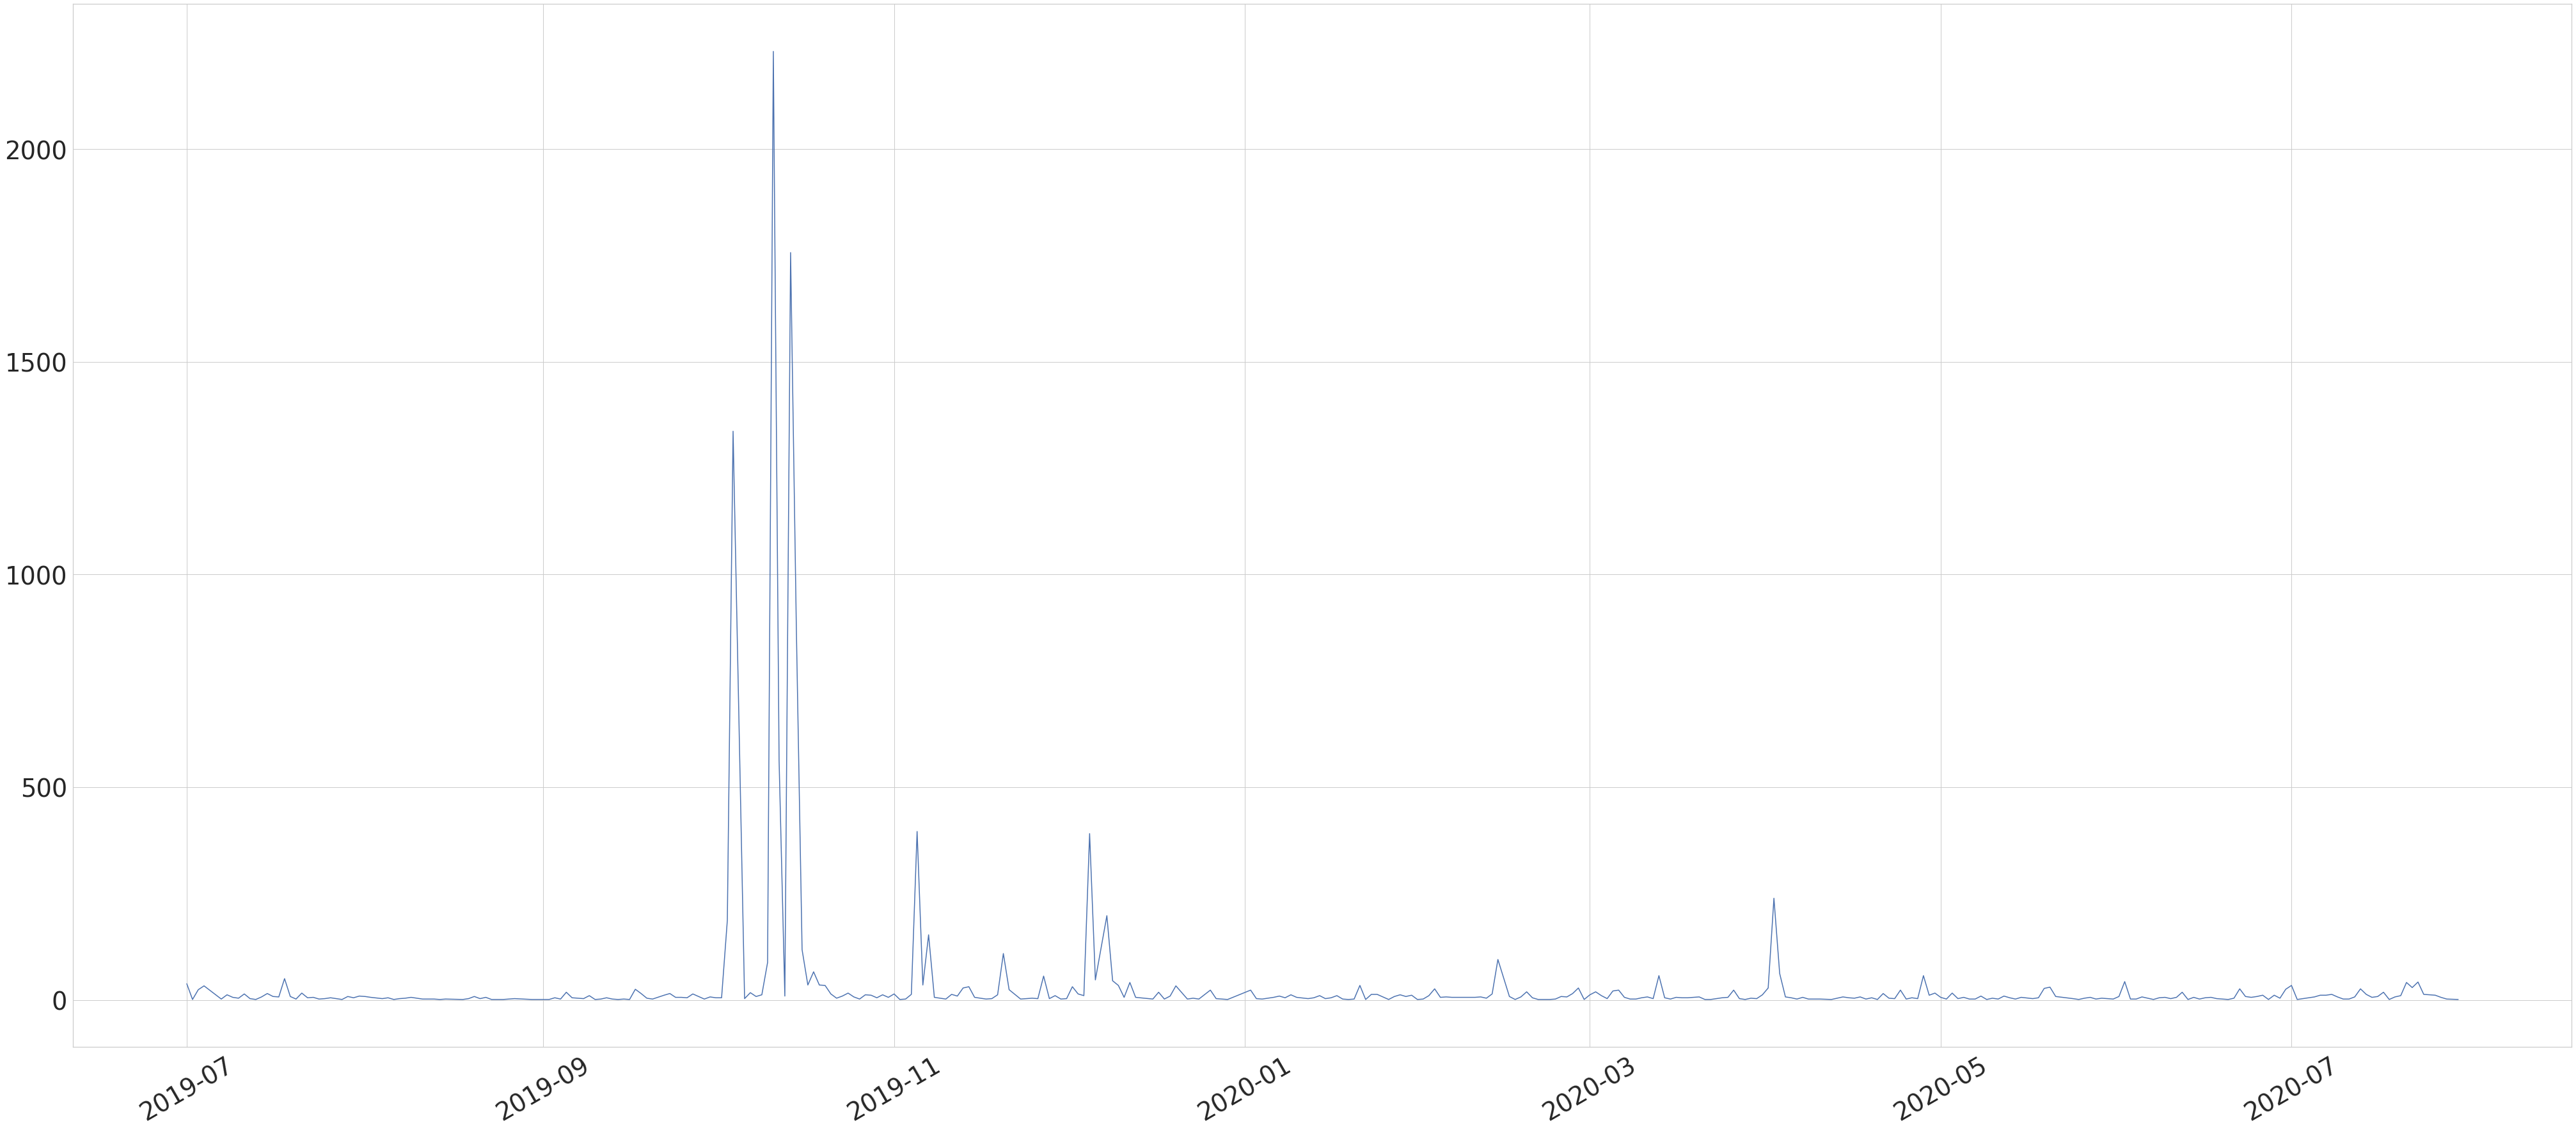

In [48]:
_ = data.date.value_counts().plot()
plt.xticks(rotation=30)

In [49]:
data = data.sort_values(by="date")

data

time                                           headline  \
993956   11:44:11.523000  *VANROEKEL SAYS HE WILL FOCUS ON A SECURE, MOB...   
81391    13:24:51.178000  First Tool to Find and Patch All Security Hole...   
974734   10:23:18.269000  *VANROEKEL AIMS TO `MANIACALLY' REDUCE WASTE  ...   
974740   10:23:19.274000  *U.S. CTO STEVEN VANROEKEL SPEAKS ON CALL     ...   
974744   10:23:19.275000  *OMB TO RETAKE CONTROL OF TECH REVIEWS FROM AG...   
...                  ...                                                ...   
2020035  12:30:00.425000  Riverbed Cloud-Based Application Acceleration ...   
2022755  18:30:00.755000  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  13:00:01.449000  Insight Earns Advanced Specialization in Four ...   
2031417  06:11:00.356000  3CLogic Announces New Cloud Call Center Soluti...   
2049848  13:30:01.011000  Piazza Q&A Launches App within Microsoft Teams...   

                                                      text  \
993956   STORY TO FOLLOW.\n\n--MICHAEL SHEPARD\n\n-0- O...   
81391    Machine - STAT Scanner Released by \nSoftware ...   
974734   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974740   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974744   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
...                                                    ...   
2020035  Riverbed Cloud-Based Application Acceleration ...   
2022755  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  Insight Earns Advanced Specialization in Four ...   
2031417  3CLogic Announces New Cloud Call Center Soluti...   
2049848  Piazza Q&A Launches App within Microsoft Teams...   

                                                   dtopics  \
993956   [{'Id': 'TEL', 'score': '70'}, {'Id': 'BIZNEWS...   
81391    [{'Id': 'SME', 'score': '87'}, {'Id': 'BIZNEWS...   
974734   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974740   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974744   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
...                                                    ...   
2020035  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...   
2022755  [{'Id': 'BIZNEWS', 'score': '90'}, {'Id': 'CPN...   
2044836  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...   
2031417  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'MS...   
2049848  [{'Id': 'VIRALILL', 'score': '75'}, {'Id': 'CP...   

                                                  dtickers        date  year  \
993956   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'XRX', ...  2019-07-01  2019   
81391                      [{'Id': 'MSFT', 'score': '84'}]  2019-07-01  2019   
974734   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974740   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974744   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
...                                                    ...         ...   ...   
2020035                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2022755                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2044836  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'NSIT'...  2020-07-28  2020   
2031417  [{'Id': 'MSFT', 'score': '100'}, {'Id': '09595...  2020-07-28  2020   
2049848                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-30  2020   

         month  day  
993956       7    1  
81391        7    1  
974734       7    1  
974740       7    1  
974744       7    1  
...        ...  ...  
2020035      7   27  
2022755      7   27  
2044836      7   28  
2031417      7   28  
2049848      7   30  

[11923 rows x 9 columns]

In [50]:
data.head()

time                                           headline  \
993956  11:44:11.523000  *VANROEKEL SAYS HE WILL FOCUS ON A SECURE, MOB...   
81391   13:24:51.178000  First Tool to Find and Patch All Security Hole...   
974734  10:23:18.269000  *VANROEKEL AIMS TO `MANIACALLY' REDUCE WASTE  ...   
974740  10:23:19.274000  *U.S. CTO STEVEN VANROEKEL SPEAKS ON CALL     ...   
974744  10:23:19.275000  *OMB TO RETAKE CONTROL OF TECH REVIEWS FROM AG...   

                                                     text  \
993956  STORY TO FOLLOW.\n\n--MICHAEL SHEPARD\n\n-0- O...   
81391   Machine - STAT Scanner Released by \nSoftware ...   
974734  STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974740  STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974744  STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   

                                                  dtopics  \
993956  [{'Id': 'TEL', 'score': '70'}, {'Id': 'BIZNEWS...   
81391   [{'Id': 'SME', 'score': '87'}, {'Id': 'BIZNEWS...   
974734  [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974740  [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974744  [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   

                                                 dtickers        date  year  \
993956  [{'Id': 'MSFT', 'score': '96'}, {'Id': 'XRX', ...  2019-07-01  2019   
81391                     [{'Id': 'MSFT', 'score': '84'}]  2019-07-01  2019   
974734  [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974740  [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974744  [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   

        month  day  
993956      7    1  
81391       7    1  
974734      7    1  
974740      7    1  
974744      7    1

In [51]:
data.tail()

time                                           headline  \
2020035  12:30:00.425000  Riverbed Cloud-Based Application Acceleration ...   
2022755  18:30:00.755000  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  13:00:01.449000  Insight Earns Advanced Specialization in Four ...   
2031417  06:11:00.356000  3CLogic Announces New Cloud Call Center Soluti...   
2049848  13:30:01.011000  Piazza Q&A Launches App within Microsoft Teams...   

                                                      text  \
2020035  Riverbed Cloud-Based Application Acceleration ...   
2022755  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  Insight Earns Advanced Specialization in Four ...   
2031417  3CLogic Announces New Cloud Call Center Soluti...   
2049848  Piazza Q&A Launches App within Microsoft Teams...   

                                                   dtopics  \
2020035  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...   
2022755  [{'Id': 'BIZNEWS', 'score': '90'}, {'Id': 'CPN...   
2044836  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...   
2031417  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'MS...   
2049848  [{'Id': 'VIRALILL', 'score': '75'}, {'Id': 'CP...   

                                                  dtickers        date  year  \
2020035                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2022755                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2044836  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'NSIT'...  2020-07-28  2020   
2031417  [{'Id': 'MSFT', 'score': '100'}, {'Id': '09595...  2020-07-28  2020   
2049848                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-30  2020   

         month  day  
2020035      7   27  
2022755      7   27  
2044836      7   28  
2031417      7   28  
2049848      7   30

In [52]:
def remove_noise(text):
    while '--' in text:
        text = text[text.index('--')+2:]
    if '. Visit' in text:
        text = text[:text.index('. Visit')]
    if '. visit' in text:
        text = text[:text.index('. visit')]
    while '-0-' in text:
        text = text[:text.index('-0-')]
    while ' SOURCE ' in text:
        text = text[:text.index(' SOURCE ')]
    while 'NOTE:' in text:
        text = text[:text.index('NOTE:')]
    while 'More information can be found' in text:
        text = text[:text.index('More information can be found')]
    while 'CONTACT:' in text:
        text = text[:text.index('CONTACT:')]
    while 'For more information' in text:
        text = text[:text.index('For more information')]
    while 'NOTE TO EDITORS:' in text:
        text = text[:text.index('NOTE TO EDITORS:')]
    while 'can be found at' in text:
        text = text[:text.index('can be found at')]
    while 'View source version' in text:
        text = text[:text.index('View source version')]
    text = text.replace('STORY TO FOLLOW', '')

    return text

In [55]:
data

time                                           headline  \
993956   11:44:11.523000  *VANROEKEL SAYS HE WILL FOCUS ON A SECURE, MOB...   
81391    13:24:51.178000  First Tool to Find and Patch All Security Hole...   
974734   10:23:18.269000  *VANROEKEL AIMS TO `MANIACALLY' REDUCE WASTE  ...   
974740   10:23:19.274000  *U.S. CTO STEVEN VANROEKEL SPEAKS ON CALL     ...   
974744   10:23:19.275000  *OMB TO RETAKE CONTROL OF TECH REVIEWS FROM AG...   
...                  ...                                                ...   
2020035  12:30:00.425000  Riverbed Cloud-Based Application Acceleration ...   
2022755  18:30:00.755000  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  13:00:01.449000  Insight Earns Advanced Specialization in Four ...   
2031417  06:11:00.356000  3CLogic Announces New Cloud Call Center Soluti...   
2049848  13:30:01.011000  Piazza Q&A Launches App within Microsoft Teams...   

                                                      text  \
993956   STORY TO FOLLOW.\n\n--MICHAEL SHEPARD\n\n-0- O...   
81391    Machine - STAT Scanner Released by \nSoftware ...   
974734   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974740   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
974744   STORY TO FOLLOW.\n\n--SOPHIA YAN\n\n-0- Feb/13...   
...                                                    ...   
2020035  Riverbed Cloud-Based Application Acceleration ...   
2022755  Avtex Achieves the 2020/2021 Inner Circle for ...   
2044836  Insight Earns Advanced Specialization in Four ...   
2031417  3CLogic Announces New Cloud Call Center Soluti...   
2049848  Piazza Q&A Launches App within Microsoft Teams...   

                                                   dtopics  \
993956   [{'Id': 'TEL', 'score': '70'}, {'Id': 'BIZNEWS...   
81391    [{'Id': 'SME', 'score': '87'}, {'Id': 'BIZNEWS...   
974734   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974740   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
974744   [{'Id': 'METALKEY', 'score': '99'}, {'Id': 'TE...   
...                                                    ...   
2020035  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...   
2022755  [{'Id': 'BIZNEWS', 'score': '90'}, {'Id': 'CPN...   
2044836  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...   
2031417  [{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'MS...   
2049848  [{'Id': 'VIRALILL', 'score': '75'}, {'Id': 'CP...   

                                                  dtickers        date  year  \
993956   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'XRX', ...  2019-07-01  2019   
81391                      [{'Id': 'MSFT', 'score': '84'}]  2019-07-01  2019   
974734   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974740   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
974744   [{'Id': 'MSFT', 'score': '96'}, {'Id': 'HPQ', ...  2019-07-01  2019   
...                                                    ...         ...   ...   
2020035                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2022755                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-27  2020   
2044836  [{'Id': 'MSFT', 'score': '100'}, {'Id': 'NSIT'...  2020-07-28  2020   
2031417  [{'Id': 'MSFT', 'score': '100'}, {'Id': '09595...  2020-07-28  2020   
2049848                   [{'Id': 'MSFT', 'score': '100'}]  2020-07-30  2020   

         month  day  
993956       7    1  
81391        7    1  
974734       7    1  
974740       7    1  
974744       7    1  
...        ...  ...  
2020035      7   27  
2022755      7   27  
2044836      7   28  
2031417      7   28  
2049848      7   30  

[11923 rows x 9 columns]

In [56]:
stop_words = stop_words + new_stop_words + ['editor', 'contact', 'bloomberg', 'news', 'reporter', 'msft', 'window', 
'information', 'story', 'york', 'prn', 'san', 'bus', 'based', 'first', 
'help', 'today', 'including', 'top', 'site', 'related', 'princeton', 
'reporting', 'use', 'washington', 'click', 'say', 'announced', 
'best', 'yhoo', 'people', 'well', 'make', 'cnp', 'seattle', 
'taginfo', 'highavailability', 'full', 'end', 'using', 'eng',
'est', 'ticker', 'company']

In [57]:
len(data.date.unique()), 'days'

(350, 'days')

In [58]:
from tqdm import tqdm
from itertools import chain

dates = []
corpus = []
#for date in tqdm(data.date.unique(), total=len(data.date.unique())):
for _, item in tqdm(data.iterrows(), total=len(data)):
    
    #articles_per_day = data[data.date == date]
    #text = ' '.join([pre_process(remove_noise(text), return_tokens=False) \
    #                 for text in articles_per_day['text'].tolist()])
    
    text = ' '.join(pre_process(remove_noise(item.text)))
    if len(text.split(' ')) > 10:
        corpus.append(text)
        dates.append(item.date)



100%|██████████| 11923/11923 [00:30<00:00, 387.74it/s]


In [225]:
days = []
texts = []
for date in tqdm(data.date.unique(), total=len(data.date.unique())):
#for _, item in tqdm(data.iterrows(), total=len(data)):
    
    articles_per_day = data[data.date == date]
    text = ' '.join([pre_process(remove_noise(text), return_tokens=False) \
                     for text in articles_per_day['text'].tolist()])
    
    #text = ' '.join(pre_process(remove_noise(item.text)))
    if len(text.split(' ')) > 10:
        texts.append(text)
        days.append(date)
    

100%|██████████| 307/307 [00:27<00:00, 11.16it/s]


In [231]:
len(texts), len(days)

(307, 307)

In [439]:
# Create a new dataset with a sliding window of 7 days

dates = []
corpus = []

for _, item in enumerate(zip(sliding_window(days, 7), sliding_window(texts, 7))):
    window_days, window_texts = item
    dates.append(window_days[-1])
    corpus.append(' '.join(window_texts).split(' '))
    
windows_data = pd.DataFrame()
windows_data["date"] = dates
windows_data["tokens"] = corpus

windows_data['year'] = windows_data['date'].apply(lambda date: str(date)[:4])
windows_data['month'] = windows_data['date'].apply(lambda date: str(date)[:7])
windows_data['day'] = windows_data['date'].apply(lambda date: str(date)[:10])

windows_data.head()

date                                             tokens  year  \
0  2019-11-02  [october, gitex, technology, week, avaya, glob...  2019   
1  2019-11-28  [november, find, early, xbox, one, xbox, live,...  2019   
2  2019-09-06  [july, xbox, playstation, nintendo, prime, day...  2019   
3  2019-12-13  [november, surface, cyber, monday, deal, shown...  2019   
4  2019-10-14  [december, search, cyber, monday, gaming, head...  2019   

     month         day  
0  2019-11  2019-11-02  
1  2019-11  2019-11-28  
2  2019-09  2019-09-06  
3  2019-12  2019-12-13  
4  2019-10  2019-10-14

In [348]:
len(windows_data)

301

In [463]:
bgs = nltk.bigrams(list(chain(*windows_data.tokens.to_list())))
fdist = nltk.FreqDist(bgs)

print(fdist.most_common(230))


[(('industry', 'category'), 30400), (('category', 'region'), 30358), (('illustration', 'graph'), 6657), (('region', 'industry'), 6321), (('equity', 'research'), 5971), (('press', 'release'), 4491), (('dina', 'bass'), 4182), (('cesca', 'antonelli'), 4109), (('microsoft', 'azure'), 3822), (('following', 'industry'), 3546), (('industry', 'code'), 3546), (('accessible', 'following'), 3532), (('francisco', 'newsroom'), 3416), (('release', 'accessible'), 3168), (('active', 'stock'), 3129), (('jonathan', 'thaw'), 2912), (('illustration', 'list'), 2702), (('antonelli', 'fantonelli'), 2688), (('los', 'angeles'), 2614), (('bass', 'dba'), 2579), (('vice', 'president'), 2571), (('index', 'spx'), 2492), (('region', 'internet'), 2482), (('list', 'active'), 2471), (('series', 'function'), 2457), (('standard', 'poor'), 2454), (('responsible', 'cesca'), 2422), (('microsoft', 'team'), 2330), (('internet', 'industry'), 2303), (('volume', 'increase'), 2240), (('willing', 'pay'), 2226), (('comp', 'compare'

In [349]:
#data['tokens'] = data['text'].apply(lambda text: pre_process(remove_noise(text)))
#
#data.head()

In [350]:
windows_data = windows_data[windows_data['tokens'].map(len) > 15]

windows_data.head()

date                                             tokens  year  \
0  2019-11-02  [october, gitex, technology, week, avaya, glob...  2019   
1  2019-11-28  [november, find, early, xbox, one, xbox, live,...  2019   
2  2019-09-06  [july, xbox, playstation, nintendo, prime, day...  2019   
3  2019-12-13  [november, surface, cyber, monday, deal, shown...  2019   
4  2019-10-14  [december, search, cyber, monday, gaming, head...  2019   

     month         day  
0  2019-11  2019-11-02  
1  2019-11  2019-11-28  
2  2019-09  2019-09-06  
3  2019-12  2019-12-13  
4  2019-10  2019-10-14

In [351]:
len(windows_data)

301

In [352]:
data.dtickers.to_list()[:10]

[[{'Id': 'MSFT', 'score': '100'}, {'Id': 'AVYA', 'score': '96'}],
 [{'Id': 'MSFT', 'score': '100'}],
 [{'Id': 'MSFT', 'score': '100'}, {'Id': '7974@JP', 'score': '96'}],
 [{'Id': 'MSFT', 'score': '100'},
  {'Id': 'DELL', 'score': '98'},
  {'Id': 'AAPL', 'score': '20'},
  {'Id': '005930@KS', 'score': '25'}],
 [{'Id': 'MSFT', 'score': '100'}],
 [{'Id': 'MSFT', 'score': '100'}],
 [{'Id': 'MSFT', 'score': '100'}, {'Id': 'HEAR', 'score': '99'}],
 [{'Id': 'MSFT', 'score': '100'}],
 [{'Id': 'MSFT', 'score': '100'}, {'Id': 'EBAY', 'score': '65'}],
 [{'Id': 'MSFT', 'score': '100'},
  {'Id': 'INTC', 'score': '70'},
  {'Id': 'EBAY', 'score': '65'}]]

In [464]:
KEYWORD_LIST = ['microsoft team', 'remote work', 'data center', 'patient healthcare', 'video conference',
               'video security', 'lockdown health', 'microsoft healthcare', 'covid pandemic']

KEYWORD_LIST = ['remote work', 'video conference', 'video security', 'microsoft healthcare', 'covid pandemic']

KEYWORD_LIST = ['remote work', 'covid pandemic', 'microsoft team', 'xbox one', 'machine learning',
                'stock performance', 'sell stock', 'microsoft azure']

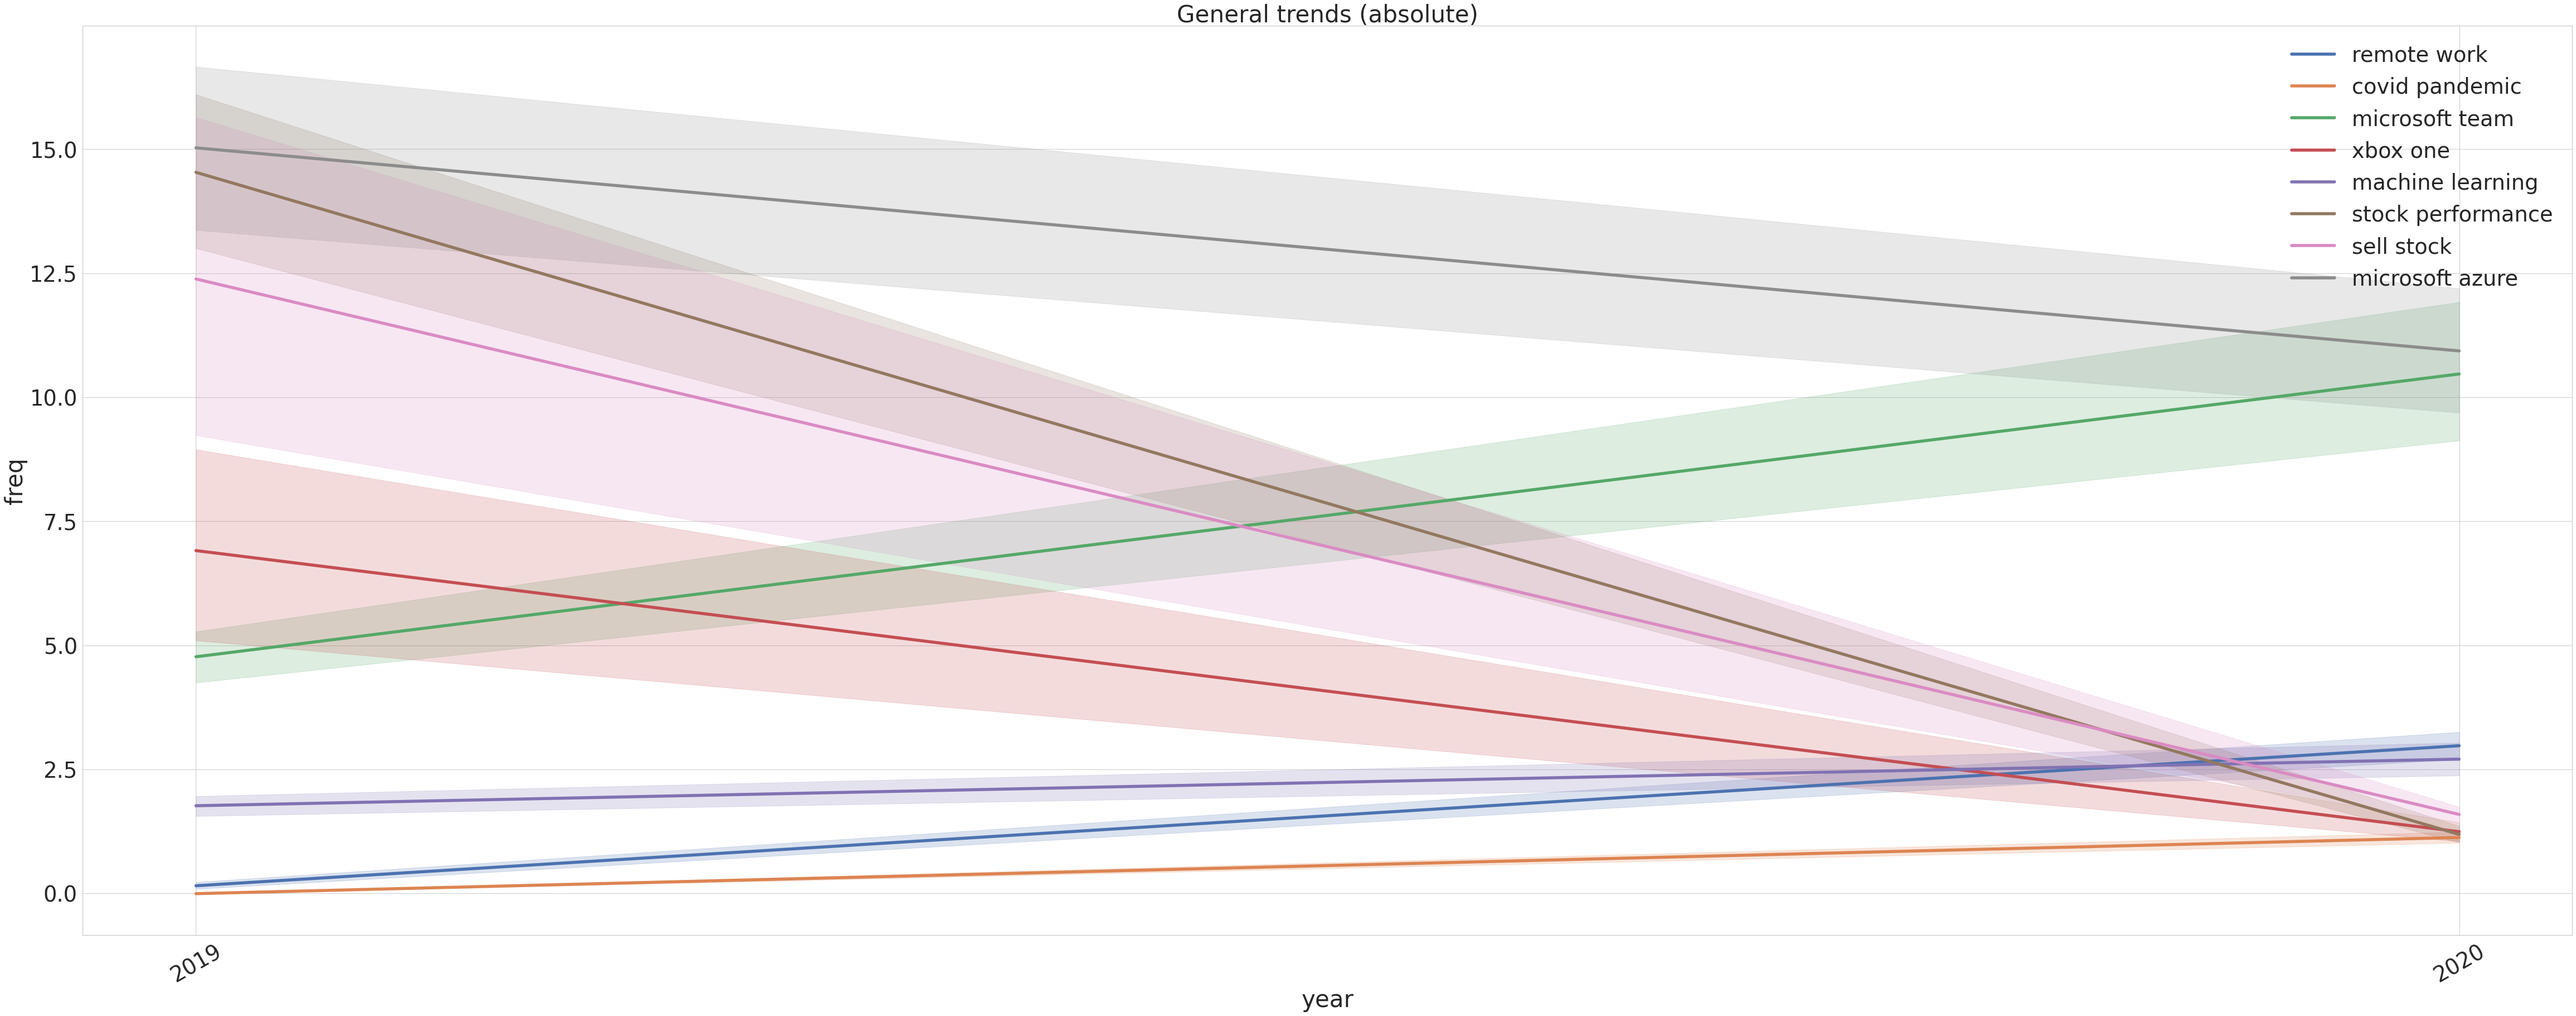

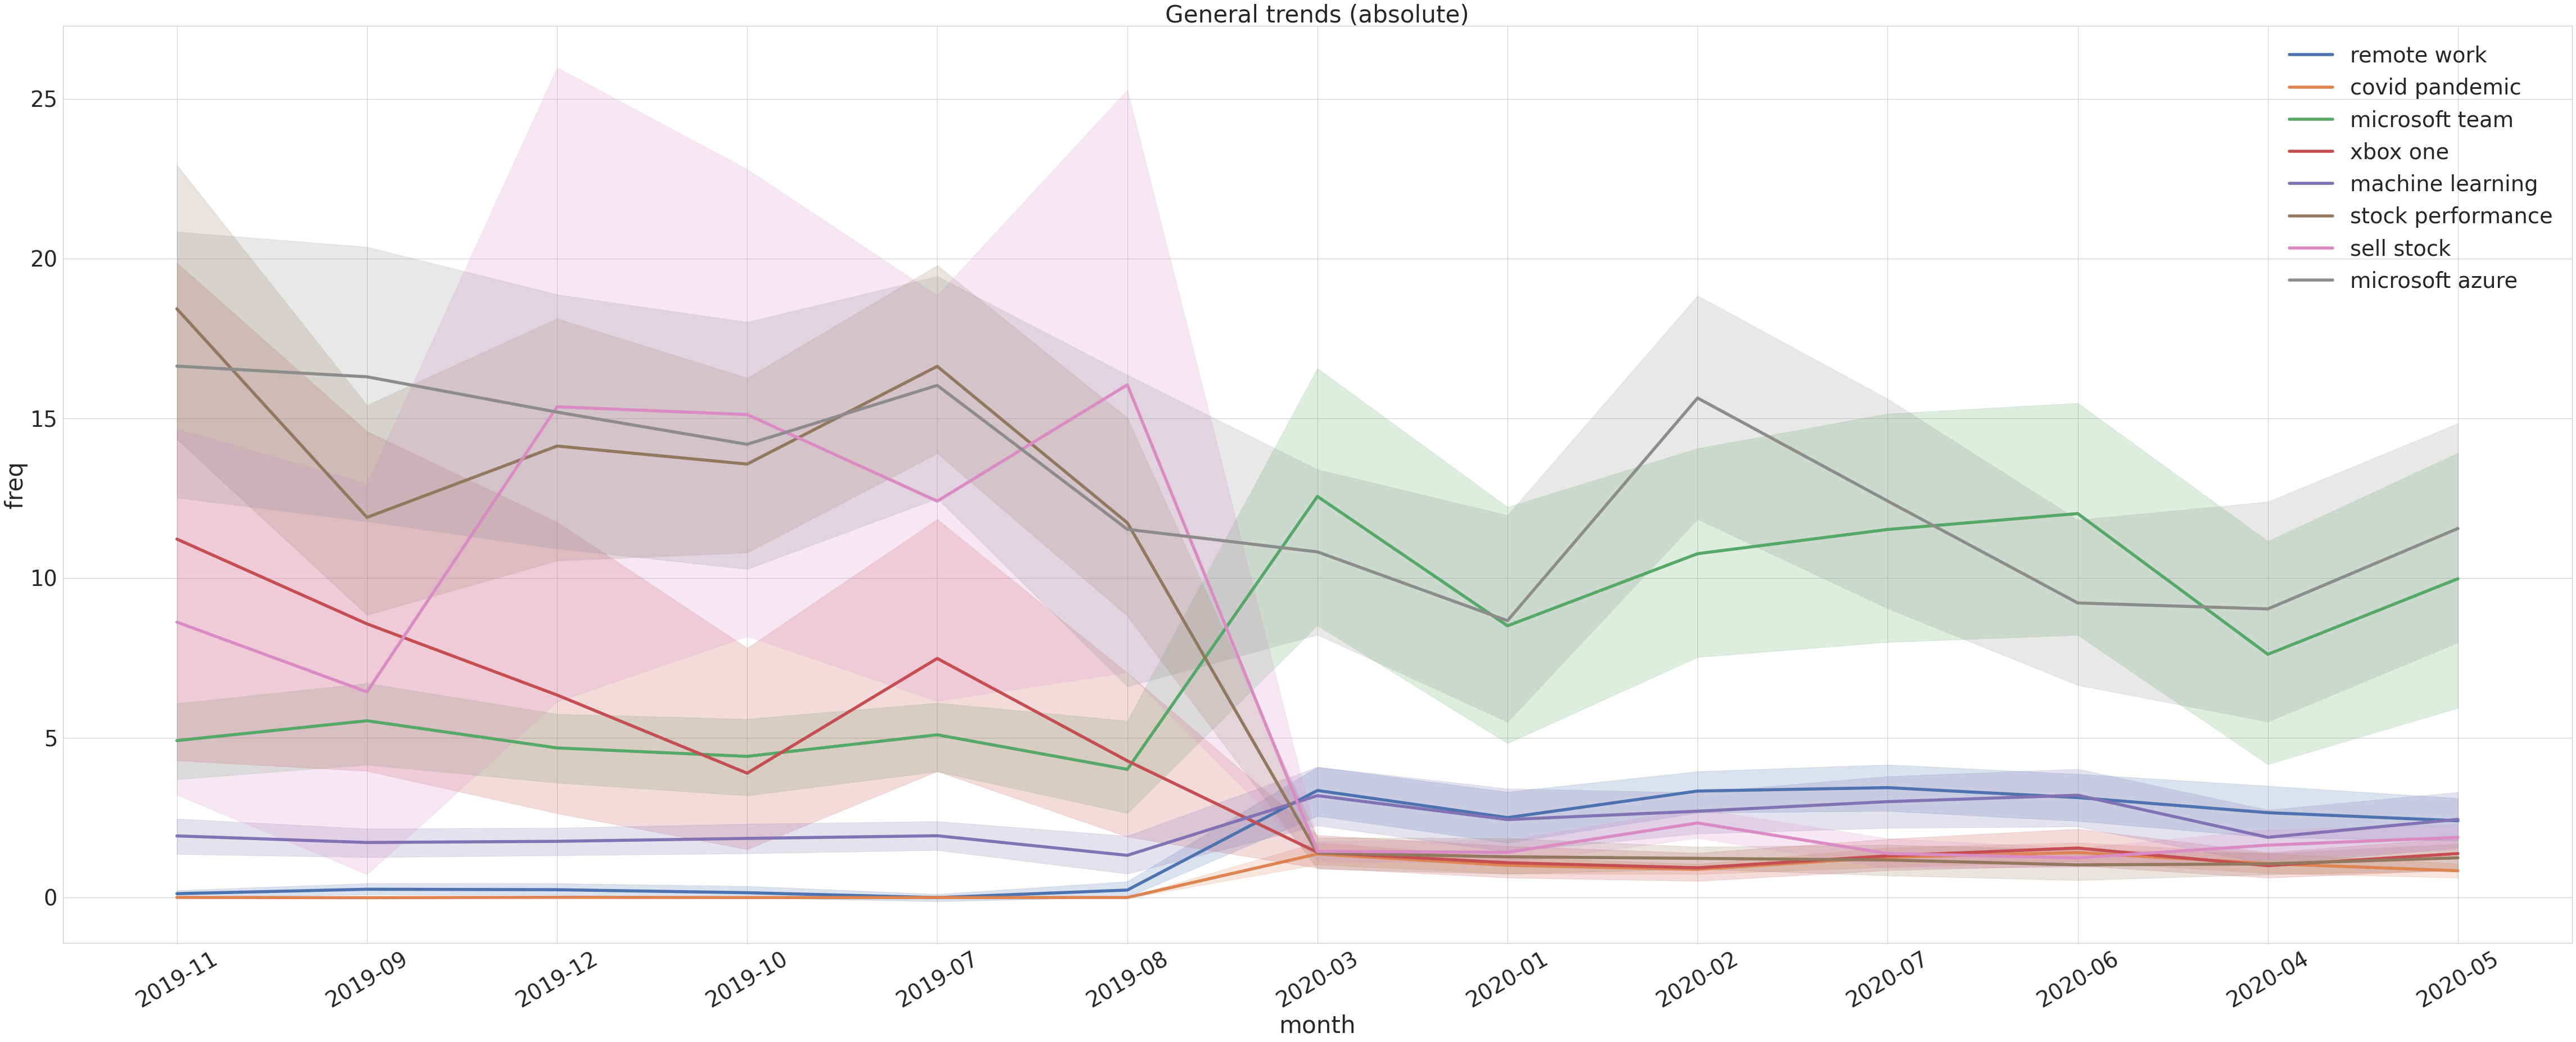

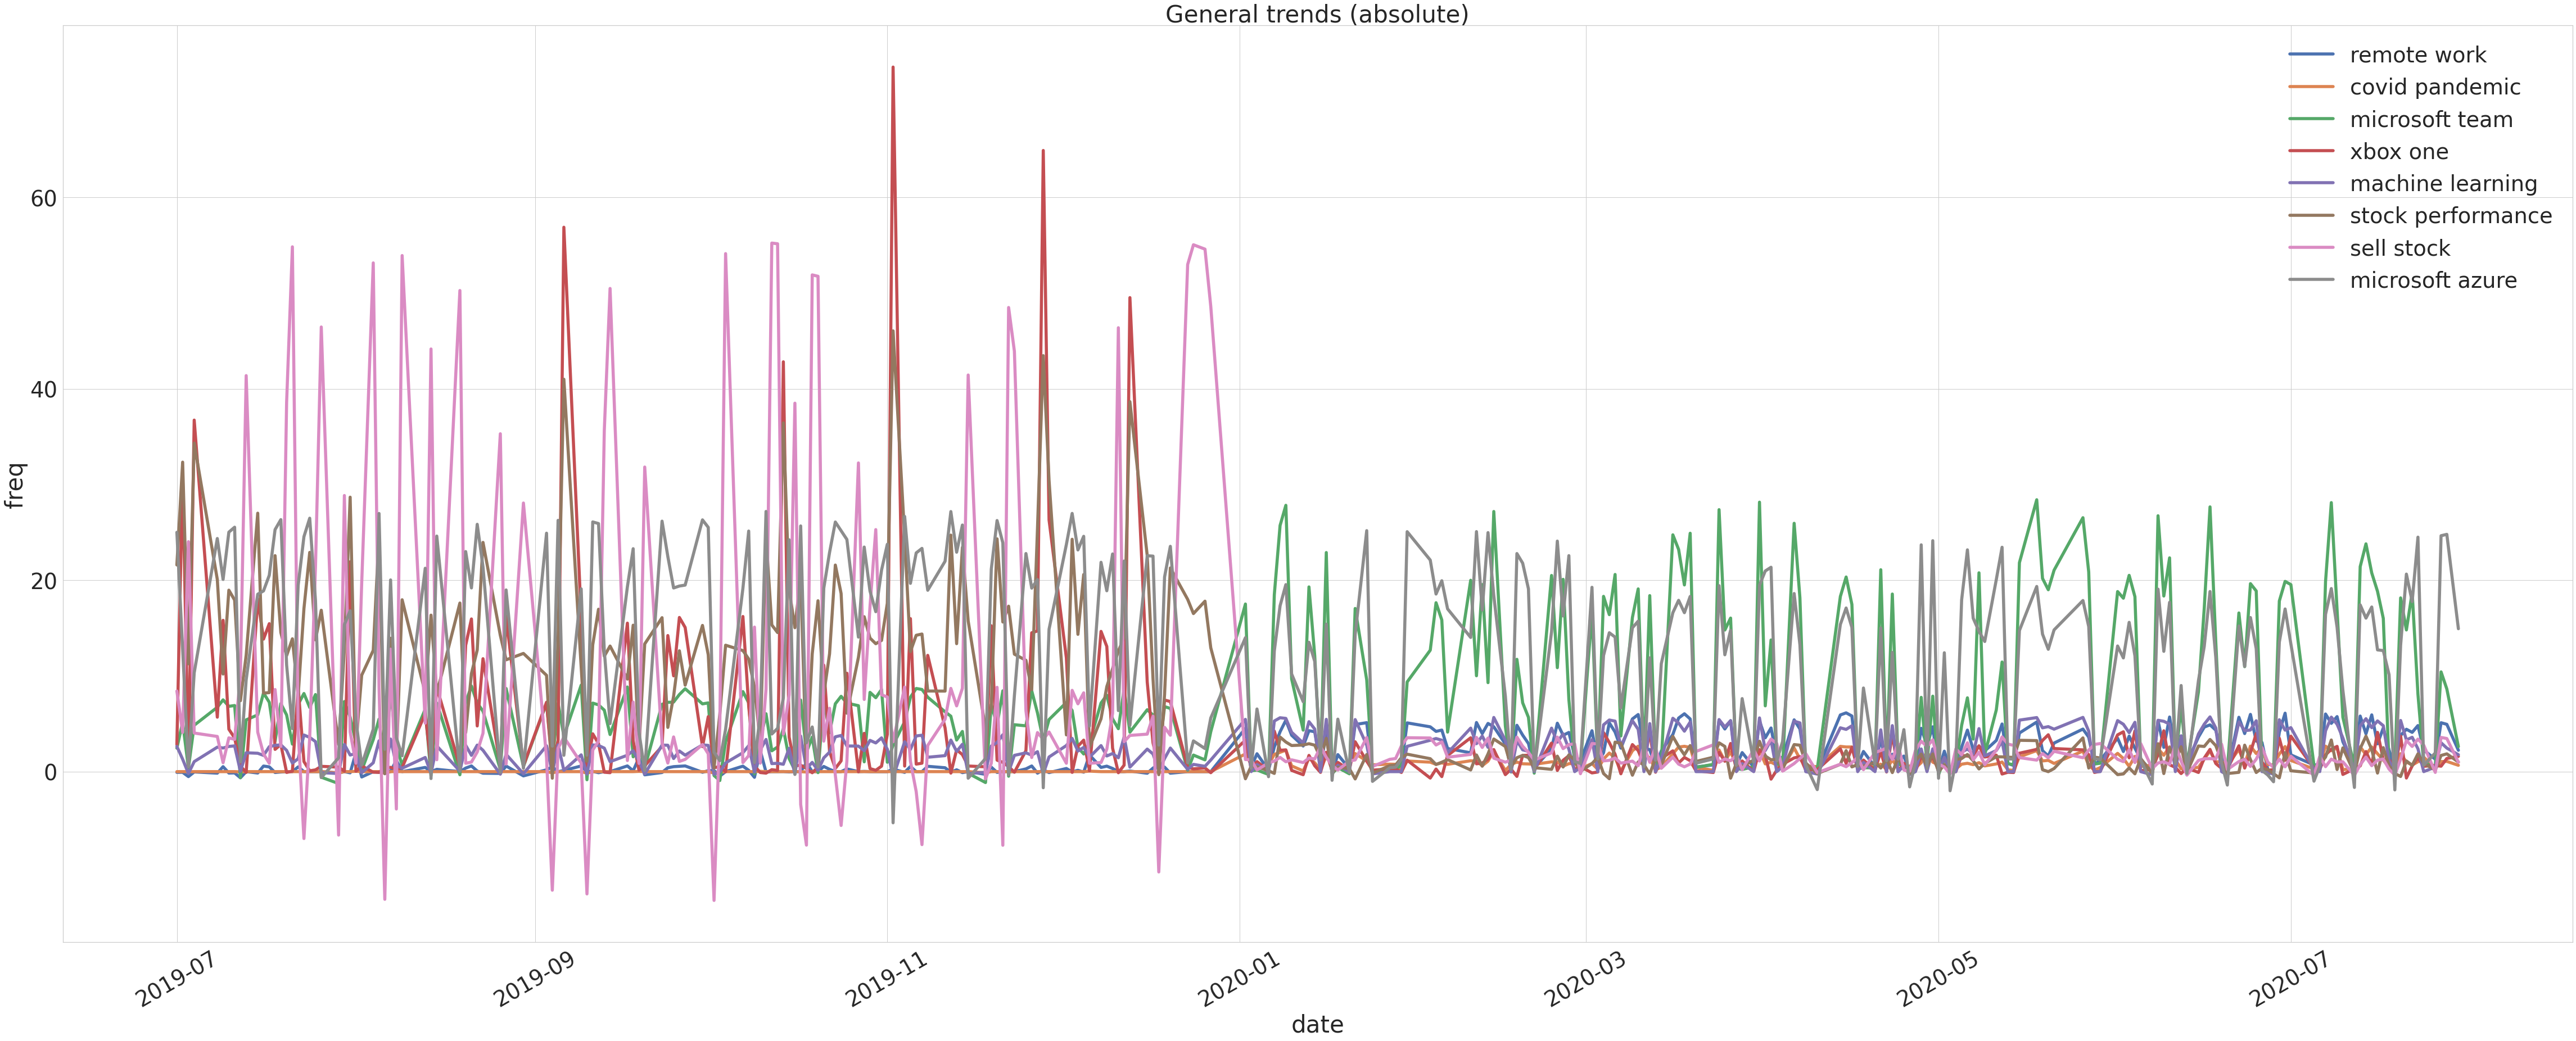

In [481]:
for period in ['year', 'month', 'date']:

    f, ax = plt.subplots(1, 1)

    for keyword in KEYWORD_LIST:
        windows_data['count_'+keyword] = windows_data['tokens'].apply(lambda tokens: ' '.join(tokens).count(keyword.lower()))
        
        #windows_data['freq'] = windows_data['freq'].rolling(134, win_type='gaussian').sum(std=134)
        windows_data['freq'] = savgol_filter(windows_data['count_'+keyword], 51, 3) # window size 51, polynomial order 3

        plot = sns.lineplot(ax=ax, data=windows_data, x=period, y='freq', linewidth = 5.5)#, err_style="bars")

    plt.xticks(rotation=30)
    #plt.ylim((-0.1, 4.2))
    ax.legend(loc='upper right', frameon=False, labels=KEYWORD_LIST)
    plt.title('General trends (absolute)')
    plt.show()

In [355]:
windows_data.tokens.to_list()[1][:30]

['november',
 'find',
 'early',
 'xbox',
 'one',
 'xbox',
 'live',
 'deal',
 'black',
 'friday',
 'list',
 'contains',
 'early',
 'xbox',
 'one',
 'one',
 'elite',
 'console',
 'controller',
 'deal',
 'reviewed',
 'updated',
 'team',
 'saver',
 'trend',
 'xbox',
 'one',
 'deal',
 'save',
 'xbox']

In [473]:
import numpy as np
def trendline(index,data, order=1):
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    return float(slope)

index = [1, 2, 3, 4]
List = [1043, 6582, 5452, 7571]
resultent = trendline(index,List)
print(resultent)  

1845.3999999999999


In [482]:
windows_data.head()

date                                             tokens  year  \
0  2019-11-02  [october, gitex, technology, week, avaya, glob...  2019   
1  2019-11-28  [november, find, early, xbox, one, xbox, live,...  2019   
2  2019-09-06  [july, xbox, playstation, nintendo, prime, day...  2019   
3  2019-12-13  [november, surface, cyber, monday, deal, shown...  2019   
4  2019-10-14  [december, search, cyber, monday, gaming, head...  2019   

     month         day      freq Up Trend Down Trend  count  \
0  2019-11  2019-11-02 -5.343841        A        NaN      0   
1  2019-11  2019-11-28 -1.681690        A        NaN      0   
2  2019-09  2019-09-06  1.706958        A        NaN      2   
3  2019-12  2019-12-13  4.831222        A        NaN      4   
4  2019-10  2019-10-14  7.700221        A        NaN      4   

   count_remote work  count_covid pandemic  count_microsoft team  \
0                  0                     0                     0   
1                  0                     0                     0   
2                  0                     0                     1   
3                  0                     0                     1   
4                  0                     0                     1   

   count_xbox one  count_machine learning  count_stock performance  \
0              66                       0                        0   
1              77                       0                        0   
2              66                       1                        0   
3              63                       1                        0   
4              48                       1                       83   

   count_sell stock  count_microsoft azure  
0                 0                      0  
1                 0                      0  
2                 0                      2  
3                 0                      4  
4                 8                      4

In [496]:
#!pip install trendet
from trendet import identify_df_trends

identify_df_trends(windows_data, 'count_xbox one', window_size=5, identify='up')

date                                             tokens  year  \
0    2019-11-02  [october, gitex, technology, week, avaya, glob...  2019   
1    2019-11-28  [november, find, early, xbox, one, xbox, live,...  2019   
2    2019-09-06  [july, xbox, playstation, nintendo, prime, day...  2019   
3    2019-12-13  [november, surface, cyber, monday, deal, shown...  2019   
4    2019-10-14  [december, search, cyber, monday, gaming, head...  2019   
..          ...                                                ...   ...   
296  2020-06-11  [paper, overnight, excess, goodwill, face, wri...  2020   
297  2020-07-24  [microsoft, plan, robotic, process, automation...  2020   
298  2020-03-11  [past, four, lucas, joppa, microsoft, old, chi...  2020   
299  2020-04-29  [sterne, agee, technical, analyst, carter, wor...  2020   
300  2020-06-26  [global, tech, major, google, microsoft, amazo...  2020   

       month         day      freq Up Trend Down Trend  count  \
0    2019-11  2019-11-02 -5.343841        A        NaN      0   
1    2019-11  2019-11-28 -1.681690        A        NaN      0   
2    2019-09  2019-09-06  1.706958        A          A      2   
3    2019-12  2019-12-13  4.831222        A          A      4   
4    2019-10  2019-10-14  7.700221        A          A      4   
..       ...         ...       ...      ...        ...    ...   
296  2020-06  2020-06-11  0.811568      NaN        NaN      1   
297  2020-07  2020-07-24  0.670921      NaN        NaN      1   
298  2020-03  2020-03-11  0.510894      NaN        NaN      1   
299  2020-04  2020-04-29  0.330678      NaN        NaN      0   
300  2020-06  2020-06-26  0.129464      NaN        NaN      0   

     count_remote work  count_covid pandemic  count_microsoft team  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     1   
3                    0                     0                     1   
4                    0                     0                     1   
..                 ...                   ...                   ...   
296                  0                     1                     1   
297                  0                     1                     1   
298                  0                     1                     1   
299                  5                     2                     1   
300                  7                     4                     1   

     count_xbox one  count_machine learning  count_stock performance  \
0                66                       0                        0   
1                77                       0                        0   
2                66                       1                        0   
3                63                       1                        0   
4                48                       1                       83   
..              ...                     ...                      ...   
296               0                       0                        1   
297               1                       0                        1   
298               1                       0                        1   
299               1                       0                        1   
300               1                       0                        1   

     count_sell stock  count_microsoft azure  
0                   0                      0  
1                   0                      0  
2                   0                      2  
3                   0                      4  
4                   8                      4  
..                ...                    ...  
296                 4                      1  
297                 3                      1  
298                 3                      1  
299                 3                      0  
300                 0                      0  

[301 rows x 17 columns]

In [356]:
#KEYWORD_LIST = ['microsoft', 'azure', 'cloud', 'security', 'million', 'team',
#                'platform', 'solution', 'business', 'technology', 'software']

In [357]:
#KEYWORD_LIST = ['microsoft', 'video', 'cloud', 'team', 'conference', 'security']

In [358]:
#KEYWORD_LIST = ['microsoft', 'remote', 'work', 'team', 'data', 'center']


In [359]:
#def get_similarity_matrix(KEYWORD_LIST, kw_list):
#    
#    similarity_matrix = []
#    common_kw_list = nlp(','.join(KEYWORD_LIST))
#    new_kw_list = nlp(','.join(kw_list))
#
#    for keyword1 in common_kw_list:
#        if keyword1.text not in [',']:
#            similarity_vector = []
#            for keyword2 in common_kw_list:
#                if keyword2.text not in [',']:
#                    
#                    if keyword1.text == keyword2.text:
#                        similarity = 1.0
#                        similarity_vector.append(similarity)
#                    else:
#                        found = False
#                        for lookout_keyword in new_kw_list:
#                            if lookout_keyword.text == keyword2.text:
#                                similarity = lookout_keyword.similarity(keyword1)
#                                found = True
#                        if found == False:
#                            similarity_vector.append(0.0)
#                        else:
#                            similarity_vector.append(similarity)
#                            
#            similarity_matrix.append(similarity_vector)
#    return np.array(similarity_matrix)

In [360]:
#!pip install itertoolz

In [361]:
from textacy.extract import utils
import itertoolz

def ngrams(
    doclike, n,
    *,
    filter_stops: bool = True,
    filter_punct: bool = True,
    filter_nums: bool = False,
    include_pos = None,
    exclude_pos = None,
    min_freq: int = 1,
):

    ns = utils.to_collection(n, int, tuple)
    if any(n_ < 1 for n_ in ns):
        raise ValueError("n must be greater than or equal to 1")

    if include_pos:
        include_pos = {
            pos.upper() for pos in utils.to_collection(include_pos, str, set)
        }
    if exclude_pos:
        exclude_pos = {
            pos.upper() for pos in utils.to_collection(exclude_pos, str, set)
        }
    for n_ in ns:
        ngrams_ = (doclike[i : i + n_] for i in range(len(doclike) - n_ + 1))
        ngrams_ = (ng for ng in ngrams_ if not any(w.is_space for w in ng))
        if filter_stops is True:
            ngrams_ = (ng for ng in ngrams_ if not ng[0].is_stop and not ng[-1].is_stop)
        if filter_punct is True:
            ngrams_ = (ng for ng in ngrams_ if not any(w.is_punct for w in ng))
        if filter_nums is True:
            ngrams_ = (ng for ng in ngrams_ if not any(w.like_num for w in ng))
        if include_pos:
            ngrams_ = (ng for ng in ngrams_ if all(w.pos_ in include_pos for w in ng))
        if exclude_pos:
            ngrams_ = (ng for ng in ngrams_ if not any(w.pos_ in exclude_pos for w in ng))
        if min_freq > 1:
            ngrams_ = list(ngrams_)
            freqs = itertoolz.frequencies(ng.text.lower() for ng in ngrams_)
            ngrams_ = (ng for ng in ngrams_ if freqs[ng.text.lower()] >= min_freq)

        for ngram in ngrams_:
            yield ngram

In [362]:
KEYWORD_LIST

['remote work', 'covid pandemic', 'microsoft team', 'xbox one']

In [363]:
nlp('UNK').tensor[0].shape


(96,)

In [364]:
import textacy
from sklearn.metrics.pairwise import cosine_similarity
def get_similarity_matrix(KEYWORD_LIST, kw_list, unigram=False):
    
    #for key in KEYWORD_LIST:
    #    if key in kw_list:
    #        print(key)

    similarity_matrix = []

    if unigram:
        new_kw_list = nlp(','.join(list(set(kw_list))))
        common_kw_list = nlp(','.join(KEYWORD_LIST))
        embeddings = [item.tensor for item in common_kw_list if item.text not in [',']]
        for keyword in new_kw_list:
            if keyword.text not in [',']:
                if keyword.text in KEYWORD_LIST:
                    embeddings[KEYWORD_LIST.index(keyword.text)] = np.mean(np.vstack((keyword.tensor, embeddings[KEYWORD_LIST.index(keyword.text)])), axis=0)
    else:
        embeddings = []
        start_idx = 0
        
        # by default: the mean of the initial keywords
        embeddings = [np.mean(nlp(item).tensor, axis=0) for item in KEYWORD_LIST]
        
        # reduce the number of tokens per sliding window (spaCy limit)
        ngrams_new_kw_list = list(ngrams(nlp(' '.join(list(set(kw_list)))), 2, min_freq=0))
        
        ngrams_common_kw_list = list(ngrams(nlp(' '.join(KEYWORD_LIST)), 2, min_freq=0))
        
        for ngram in KEYWORD_LIST:
            #found = False
            for spacy_ngram in ngrams_new_kw_list:
                if ngram == spacy_ngram.text:
                    #found = True
                    # average of the initial keyword and all the other occurences
                    embeddings[KEYWORD_LIST.index(spacy_ngram.text)] = np.mean(np.vstack((spacy_ngram.tensor, embeddings[KEYWORD_LIST.index(spacy_ngram.text)])), axis=0)
                    break
            #if found == False:
            #    embeddings[KEYWORD_LIST.index(spacy_ngram.text)] = np.mean(np.vstack((nlp(ngram).tensor, embeddings[KEYWORD_LIST.index(spacy_ngram.text)])), axis=0)
                
    return np.triu(cosine_similarity(np.array(embeddings)), 1)

In [365]:
len(KEYWORD_LIST)

4

In [366]:
import numpy as np

matrix_similarity = get_similarity_matrix(KEYWORD_LIST, KEYWORD_LIST)

matrix_similarity.shape

(4, 4)

In [367]:
np.triu(matrix_similarity, 1)

array([[0.        , 0.5251208 , 0.5678893 , 0.28632042],
       [0.        , 0.        , 0.50606996, 0.39836353],
       [0.        , 0.        , 0.        , 0.49794298],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [368]:
sorted_vector = np.flip(np.sort(np.concatenate(matrix_similarity, axis=0)))

sorted_vector

array([0.5678893 , 0.5251208 , 0.50606996, 0.49794298, 0.39836353,
       0.28632042, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [369]:
sorted_matrix = np.reshape(sorted_vector, (matrix_similarity.shape[0], matrix_similarity.shape[1]))

sorted_matrix

array([[0.5678893 , 0.5251208 , 0.50606996, 0.49794298],
       [0.39836353, 0.28632042, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [370]:
def get_ranked_matrix(matrix_similarity, sorted_matrix):

    rank = 0
    ranked_matrix = np.zeros(shape=(matrix_similarity.shape[0], matrix_similarity.shape[0]))
    
    #positions = []
    for i in range(sorted_matrix.shape[0]):
        for j in range(sorted_matrix.shape[0]):
            temp = sorted_matrix[i][j]
            
            for k in range(matrix_similarity.shape[0]):
                for p in range(matrix_similarity.shape[0]):
                    
                    #if (matrix_similarity[k][p] != 1.0) and (temp != 1.0):
                        if matrix_similarity[k][p] == temp:
                            
                            #ranked_matrix[i][j] = rank + 1
                            rank += 1
                            ranked_matrix[k][p] = rank
                            
                            #print('-'.join([KEYWORD_LIST[k], KEYWORD_LIST[p]]), k, p, i, j)
                            
                            #positions.append(('-'.join([KEYWORD_LIST[k], KEYWORD_LIST[p]]), k, k))
                            p = matrix_similarity.shape[0]
    return ranked_matrix

In [371]:
ranked_matrix = get_ranked_matrix(matrix_similarity, sorted_matrix)

ranked_matrix

array([[ 97.,   2.,   1.,   6.],
       [ 98.,  99.,   3.,   5.],
       [100., 101., 102.,   4.],
       [103., 104., 105., 106.]])

In [372]:
KEYWORD_LIST

['remote work', 'covid pandemic', 'microsoft team', 'xbox one']

In [373]:
for i in range(ranked_matrix.shape[0]):
    for j in range(i, ranked_matrix.shape[0]):
        if ranked_matrix[i][j] > 0:
            print(KEYWORD_LIST[i], KEYWORD_LIST[j], '[', i, j, ']', 'rank:', ranked_matrix[i][j])


remote work remote work [ 0 0 ] rank: 97.0
remote work covid pandemic [ 0 1 ] rank: 2.0
remote work microsoft team [ 0 2 ] rank: 1.0
remote work xbox one [ 0 3 ] rank: 6.0
covid pandemic covid pandemic [ 1 1 ] rank: 99.0
covid pandemic microsoft team [ 1 2 ] rank: 3.0
covid pandemic xbox one [ 1 3 ] rank: 5.0
microsoft team microsoft team [ 2 2 ] rank: 102.0
microsoft team xbox one [ 2 3 ] rank: 4.0
xbox one xbox one [ 3 3 ] rank: 106.0


In [374]:
for i in range(ranked_matrix.shape[0]):
    for j in range(i, ranked_matrix.shape[0]):
        if ranked_matrix[i][j] > 0:
            print(KEYWORD_LIST[i], KEYWORD_LIST[j], '[', i, j, ']', 'rank:', ranked_matrix[i][j])


remote work remote work [ 0 0 ] rank: 97.0
remote work covid pandemic [ 0 1 ] rank: 2.0
remote work microsoft team [ 0 2 ] rank: 1.0
remote work xbox one [ 0 3 ] rank: 6.0
covid pandemic covid pandemic [ 1 1 ] rank: 99.0
covid pandemic microsoft team [ 1 2 ] rank: 3.0
covid pandemic xbox one [ 1 3 ] rank: 5.0
microsoft team microsoft team [ 2 2 ] rank: 102.0
microsoft team xbox one [ 2 3 ] rank: 4.0
xbox one xbox one [ 3 3 ] rank: 106.0


In [375]:
KEYWORD_LIST

['remote work', 'covid pandemic', 'microsoft team', 'xbox one']

In [376]:
corpus[0][:40]

['october',
 'gitex',
 'technology',
 'week',
 'avaya',
 'global',
 'leader',
 'solution',
 'enhance',
 'simplify',
 'communication',
 'collaboration',
 'microsoft',
 'used',
 'gitex',
 'technology',
 'week',
 'announce',
 'join',
 'force',
 'bring',
 'centre',
 'service',
 'cloud',
 'avaya',
 'next',
 'generation',
 'center',
 'service',
 'platform',
 'available',
 'azure',
 'hosted',
 'microsoft',
 'cloud',
 'data',
 'centre',
 'abu',
 'dhabi',
 'dubai']

In [390]:
from tqdm import tqdm
from nltk import bigrams
rankings = []
count = 0

UNIGRAM = False
for index, tokens in tqdm(enumerate(windows_data.tokens.to_list()), total=len(windows_data.tokens.to_list())):
#for index, tokens in tqdm(enumerate(data.tokens.to_list()), total=len(data.tokens.to_list())):

    if UNIGRAM: 
        kw_list = list(set(tokens))
    else:
        kw_list = [' '.join(x) for x in bigrams(tokens)]
    
    matrix_similarity = get_similarity_matrix(KEYWORD_LIST, kw_list)

    sorted_vector = np.flip(np.sort(np.concatenate(matrix_similarity, axis=0)))
    sorted_matrix = np.reshape(sorted_vector, (matrix_similarity.shape[0], matrix_similarity.shape[1]))

    ranked_matrix = get_ranked_matrix(matrix_similarity, sorted_matrix)

    pair_keyword_rankings = []
    for i in range(ranked_matrix.shape[0]):
        for j in range(i, ranked_matrix.shape[0]):
            if ranked_matrix[i][j] > 0:
                if KEYWORD_LIST[i] != KEYWORD_LIST[j]:
                    pair_keyword_rankings.append(('-'.join([KEYWORD_LIST[i], KEYWORD_LIST[j]]), ranked_matrix[i][j]))
    count += 1
    rankings.append(pair_keyword_rankings)


100%|██████████| 301/301 [15:33<00:00,  3.10s/it] 


In [437]:
for rank in rankings:
    for item in rank:
        if 'microsoft team-xbox one' in item[0]:
            print(item)

('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 3.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 2.0)
('microsoft team-xbox one', 4.0)
('microsoft team-xbox one', 2.0)
('microsof

In [428]:
dates = windows_data['date'].to_list() #plots need datetime format

THRESH = 0
#dates = pd.to_datetime(dates)

pairs = []
pair_dates = []
diffs = []
articles = []
for index, rank in enumerate(rankings[:-1]):
    for keywords1 in rankings[index]:
        for keywords2 in rankings[index+1]:
            #print(keywords1[0].split('-')[0], keywords1[0].split('-')[1])
            if keywords1[0].split('-')[0] != keywords1[0].split('-')[1]:
                if keywords2[0].split('-')[0] != keywords2[0].split('-')[1]:
                    #print(keywords1[0], '--', keywords2[0], keywords2[1] - keywords1[1])

                    diff = keywords1[1] - keywords2[1]
                    #print(keywords1[0], '--', keywords2[0], keywords2[1] - keywords1[1])
                    #print(keywords1[0], diff)
                    #if diff >= THRESH:
                    #if diff < 0.0:
                    #    diff = 0.0
                    pairs.append(keywords1[0])
                    diffs.append(diff)
                    articles.append(index)
                    pair_dates.append(dates[index])

In [429]:
len(diffs), diffs[:20], len(rankings), len(dates)

(10800,
 [0.0,
  -2.0,
  -3.0,
  2.0,
  -1.0,
  1.0,
  2.0,
  0.0,
  -1.0,
  4.0,
  1.0,
  3.0,
  3.0,
  1.0,
  0.0,
  5.0,
  2.0,
  4.0,
  -2.0,
  -4.0],
 301,
 301)

In [405]:
sum(diffs)

10500.0

In [406]:
fd = nltk.FreqDist(pairs) 
print(fd.most_common(30))

[x[0] for x in fd.most_common(30)]

[('covid pandemic-microsoft team', 1549), ('remote work-covid pandemic', 1394), ('microsoft team-xbox one', 1236), ('covid pandemic-xbox one', 930), ('remote work-microsoft team', 876), ('remote work-xbox one', 315)]


['covid pandemic-microsoft team',
 'remote work-covid pandemic',
 'microsoft team-xbox one',
 'covid pandemic-xbox one',
 'remote work-microsoft team',
 'remote work-xbox one']

In [407]:
dates[0], dates[-1]

(datetime.date(2019, 11, 2), datetime.date(2020, 6, 26))

In [408]:
str(dates[0]), dates[0].strftime("%Y-%m-%d")

('2019-11-02', '2019-11-02')

In [409]:
KEYWORD_LIST

['remote work', 'covid pandemic', 'microsoft team', 'xbox one']

In [410]:
a = [15, 12, 8, 8, 7, 7, 7, 6, 5, 3]
b = [10, 25, 17, 11, 13, 17, 20, 13, 9, 15]
from scipy.stats import linregress
linregress(a, b)

LinregressResult(slope=0.20833333333333331, intercept=13.375, rvalue=0.14499815458068518, pvalue=0.689401448116695, stderr=0.5026170462708364)

['covid pandemic-microsoft team', 'covid pandemic']
['microsoft team-xbox one', 'xbox one']


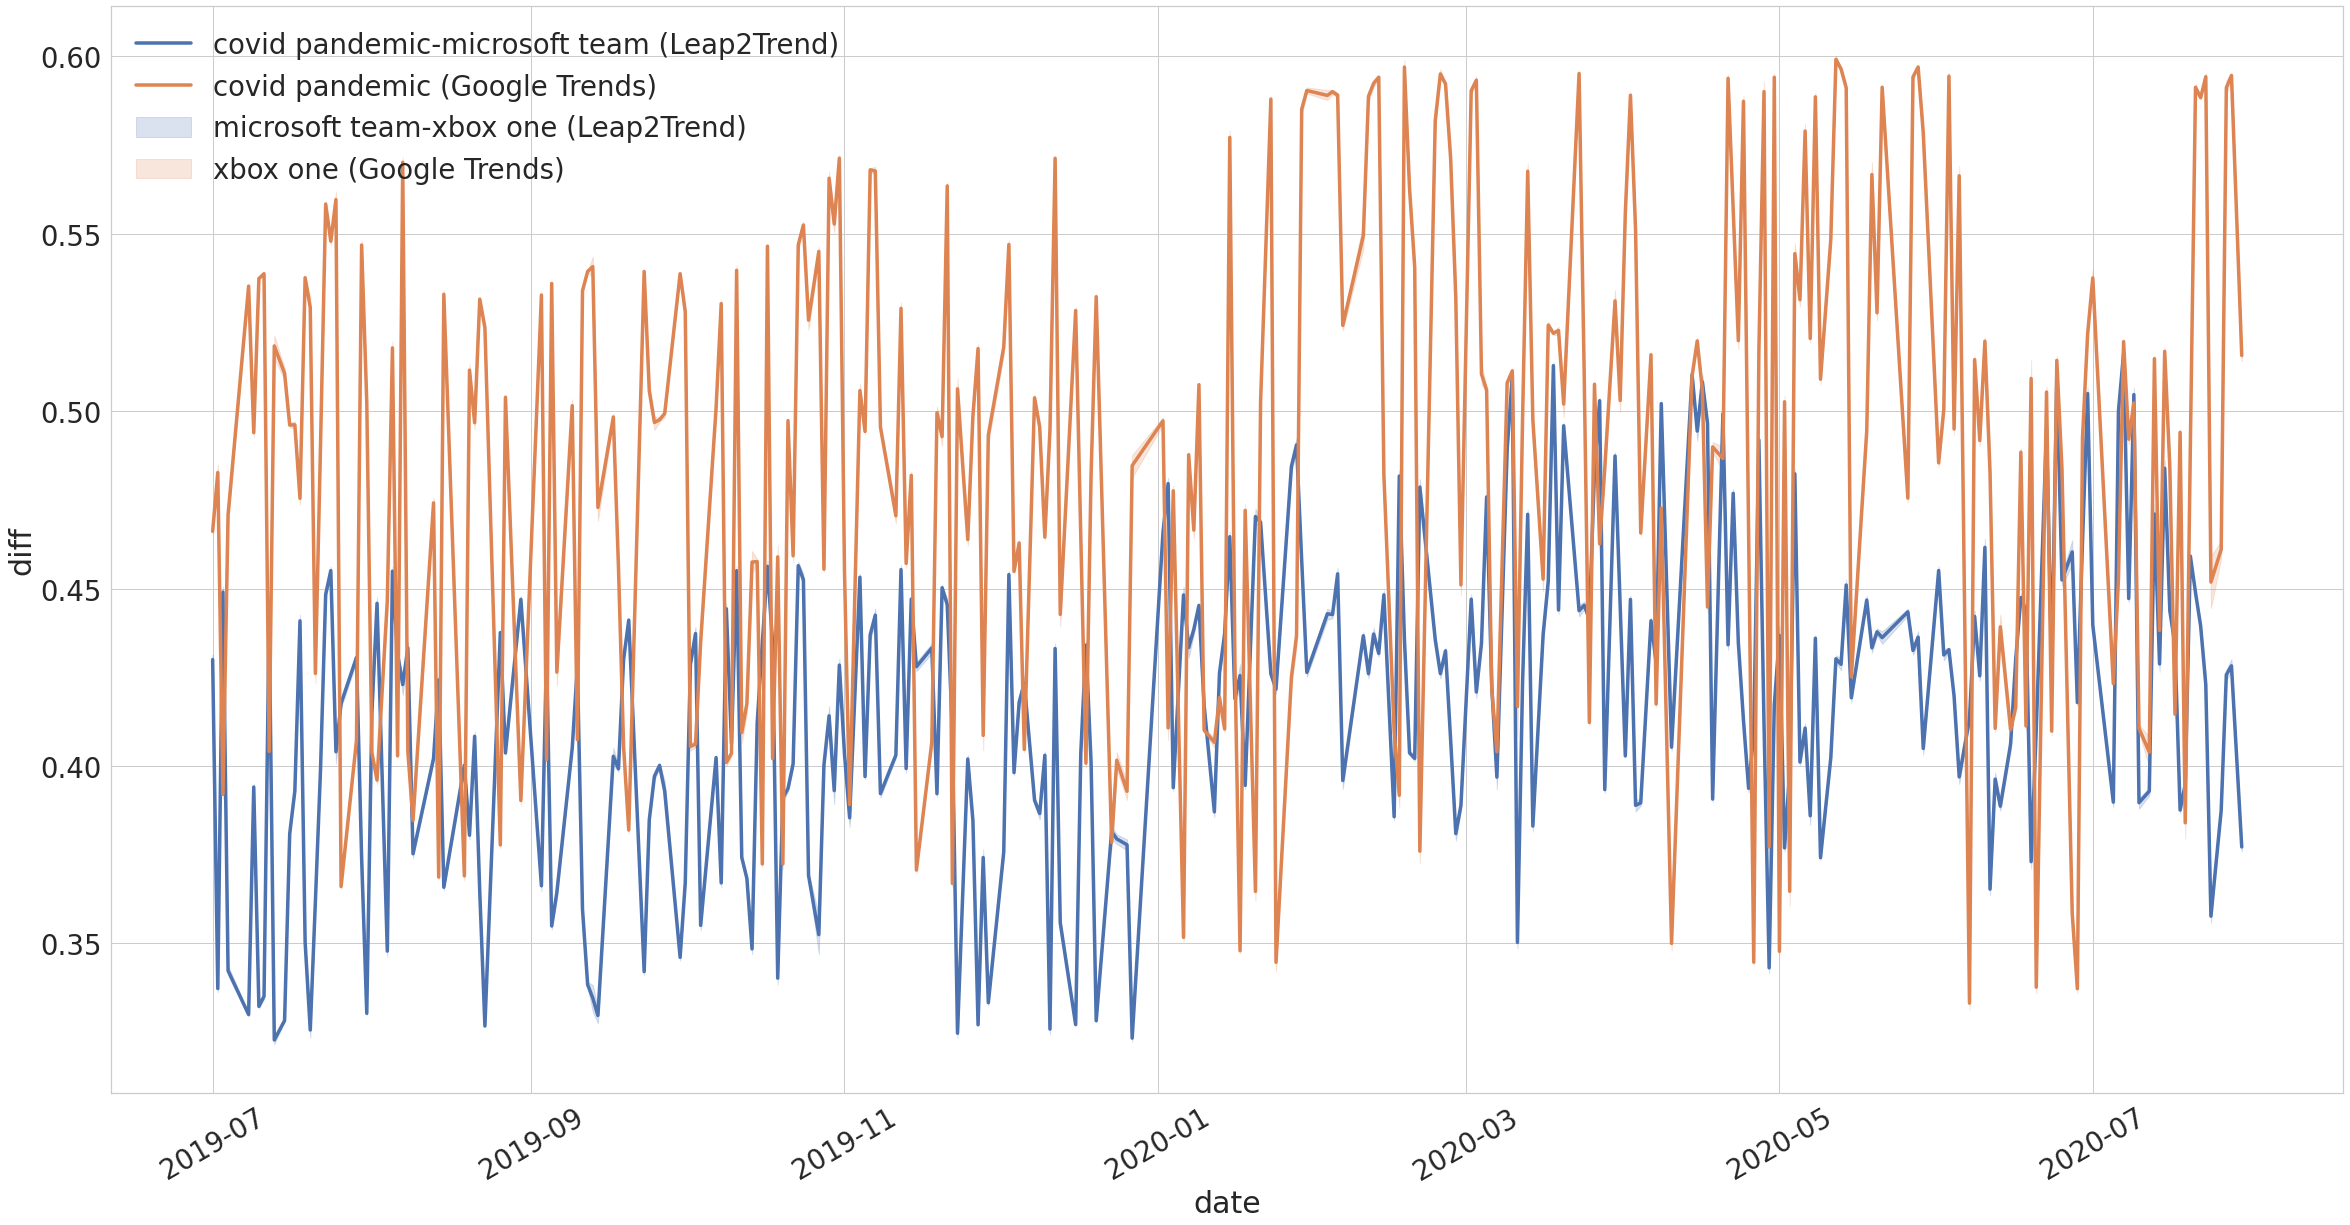

In [430]:
f, ax = plt.subplots(1, 1)
sns.set(font_scale=2.5, style="whitegrid")
plt.rcParams["figure.figsize"] = (40,20)

        
def normalize(vector):
    return (vector-min(vector))/(max(vector)-min(vector))

names = ['microsoft teams (Leap2Trend)', 'microsoft teams (Google Trends)',
         'remote work (Leap2Trend)', 'remote work (Google Trends)']
terms = [['microsoft-team', 'microsoft teams'], ['remote-work', 'remote work']]

names = [
        'covid pandemic-microsoft team (Leap2Trend)', 'covid pandemic (Google Trends)',
        'microsoft team-xbox one (Leap2Trend)', 'xbox one (Google Trends)']

terms = [
        ['covid pandemic-microsoft team', 'covid pandemic'],
        ['microsoft team-xbox one', 'xbox one']]

google = False

i = 1
for pair in terms:
    print(pair)
    x, y = [], []
    for index, pair_ in enumerate(pairs):
        #print(pair_, pair[0], diffs[index])
        if pair[0] == pair_:
            x.append(pair_dates[index])
            #print(pair_, pair[0], diffs[index])
            
            #if diffs[index] < 0.0:
             #   y.append(0.01)
            #else:
            y.append(diffs[index])

    microsoft_trends = pd.DataFrame(columns=['date', 'diff'])
    microsoft_trends['date'] = x
    microsoft_trends['diff'] = y
    
    
#    microsoft_trends['diff'] = microsoft_trends['diff'].apply(lambda count: (count*20) if count > 3 else 0)
    #microsoft_trends['diff'] = microsoft_trends['diff'].apply(lambda count: count*20)
    microsoft_trends['diff'] = normalize(microsoft_trends['diff'])
    
    
    microsoft_trends['diff'] = savgol_filter(microsoft_trends['diff'], 291, 3) # window size 51, polynomial order 3
    #print(microsoft_trends)
    #microsoft_trends['diff'] = microsoft_trends['diff'].rolling(24, win_type='triang').sum()
    #microsoft_trends['diff'] = microsoft_trends['diff'].rolling(48, win_type='gaussian').sum(std=48)
    microsoft_chart = sns.lineplot(ax=ax, data=microsoft_trends, x='date', y='diff', linewidth=3.5)

    if google:
        pytrends.build_payload([pair[1]])
        time.sleep(2)

        google_trends = pytrends.interest_over_time()
        google_trends[pair[1]] = normalize(google_trends[pair[1]])

        google_trends = google_trends.reset_index()
        google_trends = google_trends.sort_values(by="date") # sanity!
                    
        google_trends['date'] = pd.to_datetime(google_trends['date'])
        mask = (google_trends['date'] > dates[0].strftime("%Y-%m-%d")) & (google_trends['date'] <= dates[-1].strftime("%Y-%m-%d"))

        google_trends_subset = google_trends.loc[mask]
        #print(google_trends)
        #google_trends_subset[pair[1]] = google_trends_subset[pair[1]].rolling(48, win_type='gaussian').sum(std=48)
        
        #google_trends_subset[pair[1]] = savgol_filter(google_trends_subset[pair[1]], 11, 3)
        
        google_chart = sns.lineplot(ax=ax, data=google_trends_subset, x='date', y=pair[1], linewidth=3.5)

        ax.lines[i].set_linestyle("--")
        i += 2


plt.xticks(rotation=30)
   
ax.legend(loc='upper left', frameon=False, labels=names)
#ax.legend(loc='upper left', frameon=False, labels=list(chain(*terms)))
#ax.legend(loc='upper right', frameon=False, labels=[term[0] for term in terms])
plt.show()

In [412]:
from pytrends.request import TrendReq
pytrends = TrendReq()
import time

_keyword = 'microsoft teams'
pytrends.build_payload([_keyword])

df2 = pytrends.interest_over_time()
#time.sleep(2)

In [123]:
df2

microsoft teams isPartial
date                                 
2016-10-16                0     False
2016-10-23                0     False
2016-10-30                2     False
2016-11-06                1     False
2016-11-13                1     False
...                     ...       ...
2021-09-12               33     False
2021-09-19               34     False
2021-09-26               33     False
2021-10-03               34     False
2021-10-10               27      True

[261 rows x 2 columns]

In [331]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
import time

_keyword = 'microsoft teams'
pytrends.build_payload([_keyword])

df = pytrends.interest_over_time()
#time.sleep(2)

In [333]:
df = df.reset_index()

df.head()

date  microsoft teams isPartial
0 2016-10-02                0     False
1 2016-10-09                0     False
2 2016-10-16                0     False
3 2016-10-23                0     False
4 2016-10-30                2     False

In [334]:
df = df.sort_values(by="date") # sanity!

In [337]:
df = df.sort_values(by="date") # sanity!
df['date'] = pd.to_datetime(df['date'])
mask = (df['date'] > dates[0].strftime("%Y-%m-%d")) & (df['date'] <= dates[-1].strftime("%Y-%m-%d"))

df_subset = df.loc[mask]
df_subset.head()

date  microsoft teams isPartial
144 2019-07-07                5     False
145 2019-07-14                5     False
146 2019-07-21                4     False
147 2019-07-28                4     False
148 2019-08-04                5     False
149 2019-08-11                5     False
150 2019-08-18                7     False
151 2019-08-25                6     False
152 2019-09-01                6     False
153 2019-09-08                6     False
154 2019-09-15                7     False
155 2019-09-22                6     False
156 2019-09-29                6     False
157 2019-10-06                7     False
158 2019-10-13                6     False
159 2019-10-20                6     False
160 2019-10-27                6     False
161 2019-11-03                7     False
162 2019-11-10                7     False
163 2019-11-17                7     False
164 2019-11-24                6     False
165 2019-12-01                6     False
166 2019-12-08                6     False
167 2019-12-15                5     False
168 2019-12-22                2     False
169 2019-12-29                3     False
170 2020-01-05                6     False
171 2020-01-12                7     False
172 2020-01-19                7     False
173 2020-01-26                8     False
174 2020-02-02               10     False
175 2020-02-09                8     False
176 2020-02-16                9     False
177 2020-02-23                9     False
178 2020-03-01               11     False
179 2020-03-08               22     False
180 2020-03-15               82     False
181 2020-03-22              100     False
182 2020-03-29               90     False
183 2020-04-05               71     False
184 2020-04-12               75     False
185 2020-04-19               88     False
186 2020-04-26               72     False
187 2020-05-03               70     False
188 2020-05-10               66     False
189 2020-05-17               59     False
190 2020-05-24               51     False
191 2020-05-31               57     False
192 2020-06-07               52     False
193 2020-06-14               47     False
194 2020-06-21               47     False
195 2020-06-28               41     False
196 2020-07-05               41     False
197 2020-07-12               42     False
198 2020-07-19               39     False
199 2020-07-26               37     False

In [257]:
df_subset.columns

Index(['index', 'date', 'microsoft teams', 'isPartial'], dtype='object')

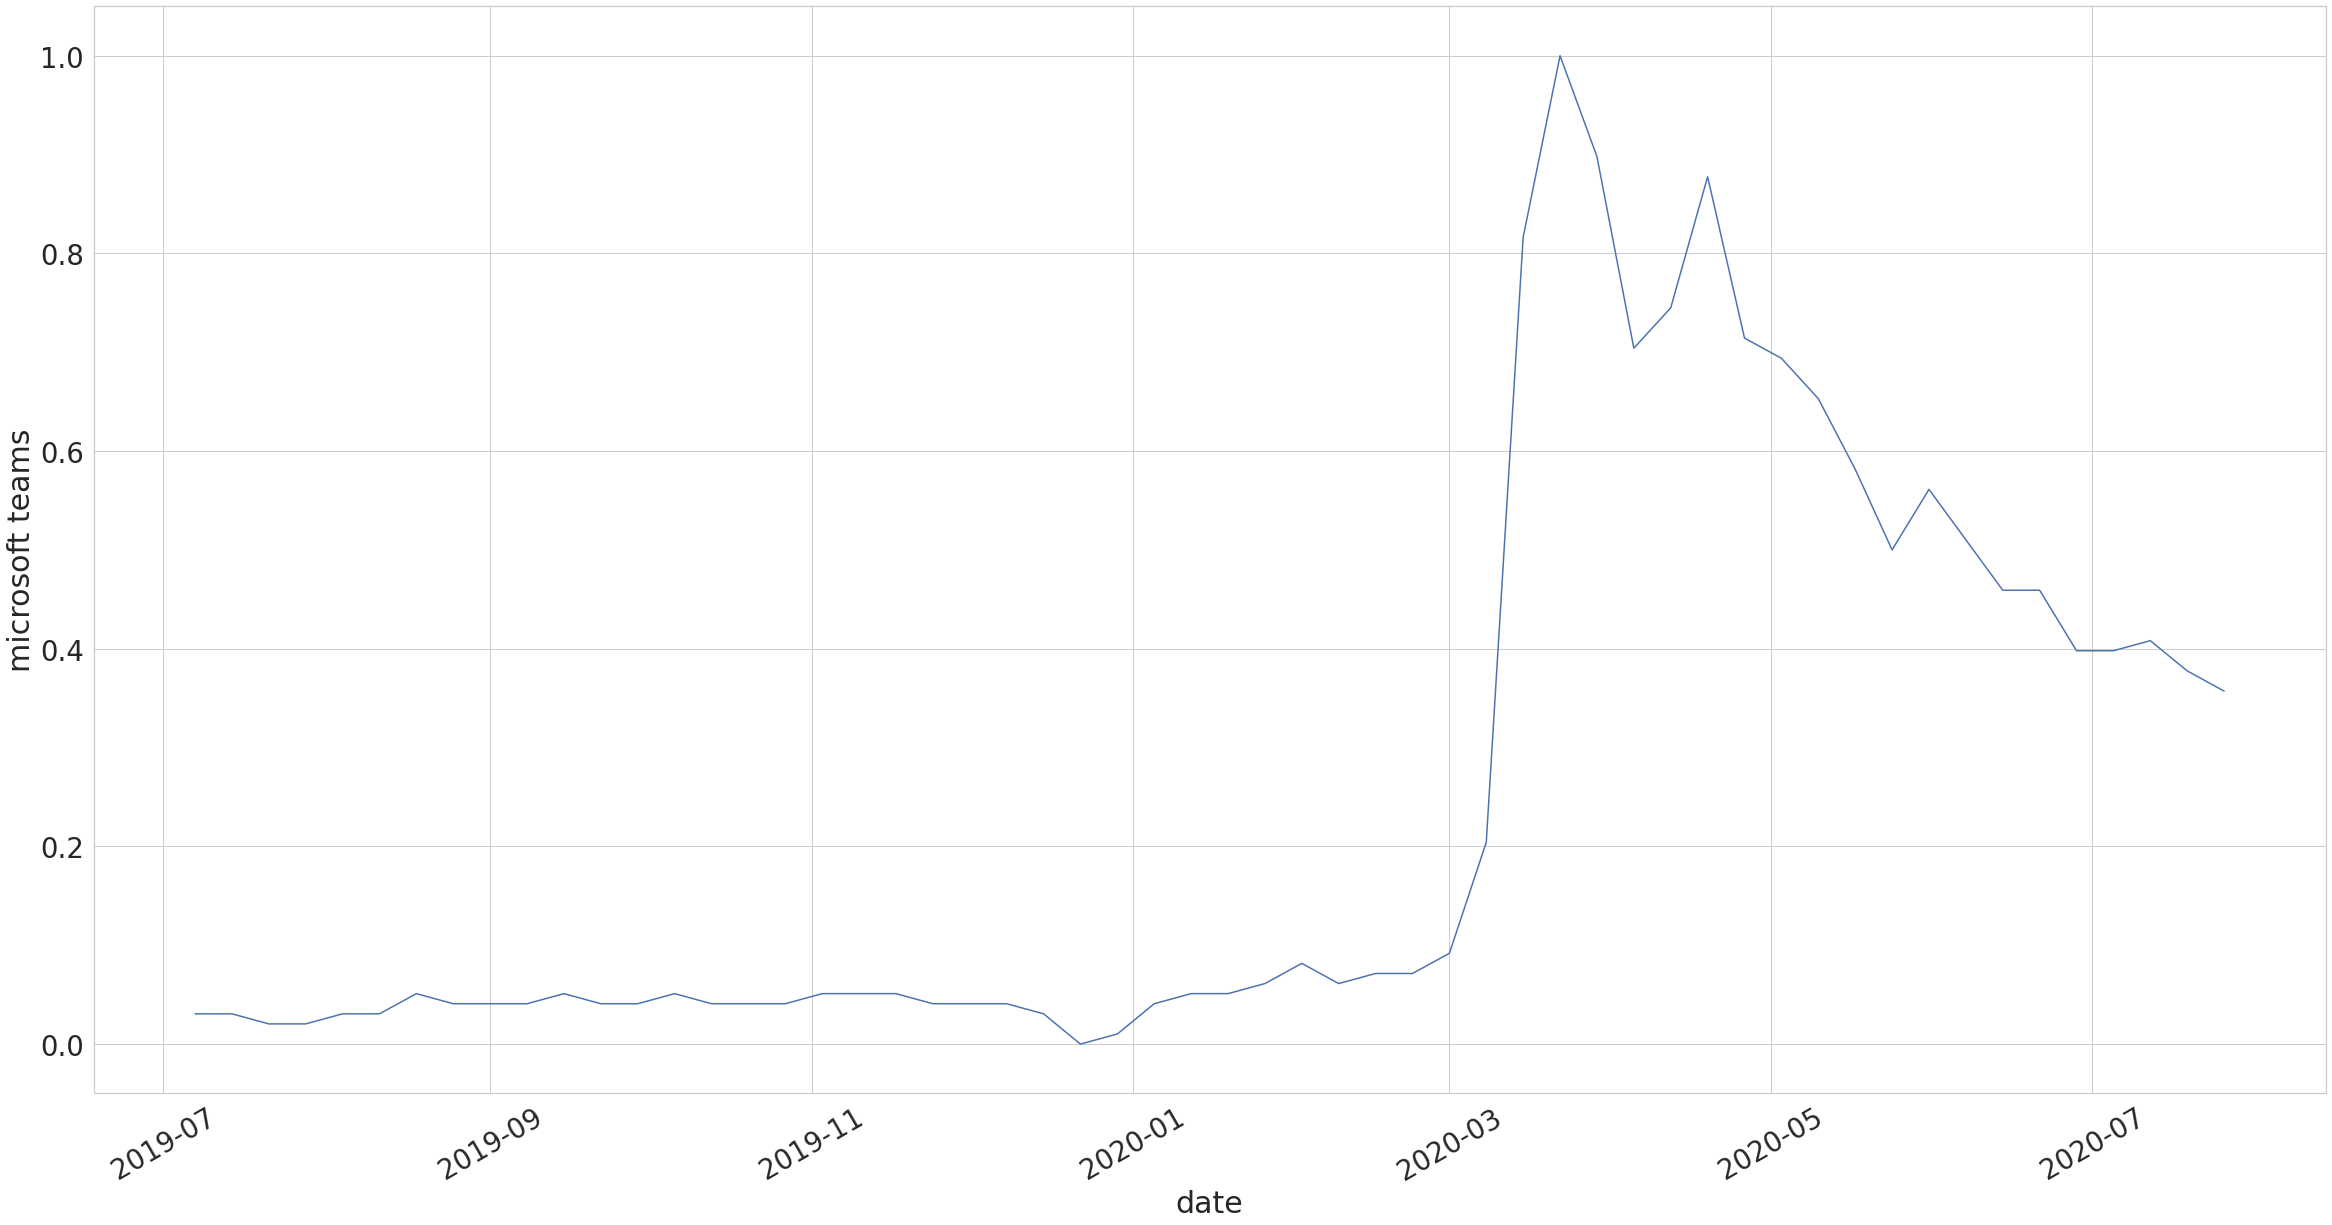

In [304]:
f, ax = plt.subplots(1, 1)
sns.set(font_scale=2.5, style="whitegrid")
plt.rcParams["figure.figsize"] = (40,20)

keywords = list(df.columns[1:])
plt.xticks(rotation=30)

df_subset[_keyword] = (df_subset[_keyword]-min(df_subset[_keyword]))/(max(df_subset[_keyword])-min(df_subset[_keyword]))

chart = sns.lineplot(ax=ax, data=df_subset, x='date', y=_keyword)
#df_subset.plot(x="date", y=_keyword)
#ax.legend(loc='upper right', frameon=False, labels=[_keyword])
plt.show()

In [139]:
import warnings
warnings.filterwarnings("ignore")

dates = [str(x) for x in dates]
dates[:3]

['2019-07-01', '2019-07-01', '2019-07-01']

In [140]:
from bertopic import BERTopic

from flair.embeddings import TransformerDocumentEmbeddings

roberta = TransformerDocumentEmbeddings('roberta-base')

#topic_model = BERTopic(embedding_model=roberta, verbose=True)
#topic_model = BERTopic(verbose=True)
topic_model = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2")

topics, probs = topic_model.fit_transform(corpus)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You try to use a model that was created with version 1.2.0, however, your version is 1.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [143]:
topics_over_time = topic_model.topics_over_time(corpus, topics, dates, nr_bins=30)

In [144]:
topic_model.visualize_topics_over_time(topics_over_time)

In [251]:
topic_model.visualize_topics_over_time(topics_over_time)